In [44]:
!git clone https://huggingface.co/datasets/khushpatel2002/triple-mnist

fatal: destination path 'triple-mnist' already exists and is not an empty directory.


In [45]:
import os
import re
import cv2
import time
import pandas
import random
import zipfile
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from random import choice
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

In [46]:
class GeneticAlgorithm:
    # Initializes the Genetic Algorithm with the required parameters and training/validation data.
    def __init__(self, population_size, num_generations, mutation_rate, x_train, y_train, x_val, y_val, verbose=False):
        self.population_size = population_size  # The number of individuals in the population.
        self.num_generations = num_generations  # The number of generations to evolve.
        self.mutation_rate = mutation_rate  # The rate at which mutations occur.
        self.x_train = x_train  # Training data inputs.
        self.y_train = y_train  # Training data outputs.
        self.x_val = x_val  # Validation data inputs.
        self.y_val = y_val  # Validation data outputs.
        self.verbose = verbose  # Whether to print detailed logs.
        self.gene_pool = set()  # Ensures all genes are unique by storing them.
        self.population = [self.create_unique_gene() for _ in range(population_size)]  # Initialize the population with unique genes.
        self.current_best_gene = None  # Stores the best gene found across all generations.
        if self.verbose:
            print(f"Initialized GA with {population_size} genes.")

    # Generates a new gene with randomly chosen parameters.
    def create_gene(self):
        # Define possible filter sizes
        filter_sizes = [3, 5, 7, 9]  # Odd numbers between 3 and 11

        # Generate gene with random selections
        gene = [
            random.randint(8, 150),  # Batch size randomly chosen between 8 and 100
            random.randint(8, 100),  # Number of filters for the first layer
            random.choice(filter_sizes),  # Filter size for the first layer
            random.randint(8, 100),  # Number of filters for the second layer
            random.choice(filter_sizes)   # Filter size for the second layer
        ]

        return gene

    # Ensures each gene is unique before adding it to the population.
    def create_unique_gene(self):
        while True:
            new_gene = self.create_gene()
            gene_tuple = tuple(new_gene)
            if gene_tuple not in self.gene_pool:
                self.gene_pool.add(gene_tuple)
                if self.verbose:
                    print(f"Added unique gene: {new_gene}")
                return new_gene

    # Orchestrates the evolution process across generations.
    def evolve(self):
        history = []

        parameter_history = []
        fitness_history = []
        for generation in range(self.num_generations):
            if self.verbose:
                print(f"\nStarting Generation {generation+1}/{self.num_generations}")
            fitness_scores = self.evaluate_population()
            fitness_history.append(fitness_scores)

            best_idx = fitness_scores.index(max(fitness_scores))
            best_gene = self.population[best_idx]
            self.current_best_gene = best_gene
            history.append((generation, best_gene, max(fitness_scores)))

            parameter_history.append([gene for gene in self.population])
            if self.verbose:
                print(f"Best gene: {best_gene} with fitness: {max(fitness_scores)}")
            self.selection(fitness_scores)
            self.crossover()
            # self.mutation()
            
        return history, parameter_history, fitness_history

    # Evaluates the current population by training and testing the CNN with each individual's gene.
    def evaluate_population(self):
        fitness_scores = []
        for gene in self.population:
            # Extract gene information
            batch_size = gene[0]
            num_filters1 = gene[1]
            filter_size1 = gene[2]
            num_filters2 = gene[3]
            filter_size2 = gene[4]

            # Set layer configuration for CNN model
            layer_config = [num_filters1, filter_size1, num_filters2, filter_size2]
            model = CNNModel(layer_config, self.verbose)
            model.train(self.x_train, self.y_train, self.x_val, self.y_val, batch_size)
            fitness = model.evaluate(self.x_val, self.y_val)
            fitness_scores.append(fitness)
            if self.verbose:
                print(f"Gene {gene} evaluated with fitness: {fitness}")

        return fitness_scores

    # Selects the best-performing individuals to continue to the next generation.
    def selection(self, fitness_scores):
        sorted_indices = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i], reverse=True)
        self.population = [self.population[i] for i in sorted_indices[:self.population_size // 2]]
        if self.verbose:
            print("Selection phase completed. Population halved.")

    # Combines genes from two parents to create new individuals.
    def crossover(self):
        next_generation = self.population.copy()
        if self.verbose:
            print("Crossover phase initiated.")
        attempts = 0
        max_attempts = 10  # Maximum attempts to generate a unique child

        while len(next_generation) < self.population_size and attempts < max_attempts:
            parent1, parent2 = random.sample(self.population, 2)
            child = [random.choice(gene) for gene in zip(parent1, parent2)]
            child_gene_tuple = tuple(child)
            if child_gene_tuple not in self.gene_pool:
                self.gene_pool.add(child_gene_tuple)
                next_generation.append(child)
                if self.verbose:
                    print(f"Crossover produced: {child}")
            attempts += 1

        if attempts == max_attempts:
            print("Max crossover attempts reached, proceeding with available population.")
        self.population = next_generation

    def get_population(self):
      return self.population

    def mutation(self):
        # Determine how many individuals to mutate based on the mutation rate
        num_to_mutate = int(len(self.population) * self.mutation_rate)
        selected_indices = random.sample(range(len(self.population)), num_to_mutate)

        for index in selected_indices:
            gene = self.population[index].copy()  # Make a copy to mutate
            mutation_index = random.randint(0, 4)  # Choose a random index in the gene to mutate

            if mutation_index in [2, 4]:
                gene[mutation_index] = random.choice([3, 5, 7, 9])
            elif mutation_index in [1, 3]:
                gene[mutation_index] = random.randint(8, 100)
            elif mutation_index == 0:
                gene[mutation_index] = random.randint(8, 150)  # Batch sizes can also be dynamic

            # Update the gene in the population
            if self.verbose:
                print(f"Mutated gene at index {index} from {self.population[index]} to {gene}")
            self.population[index] = gene


In [47]:
class CNNModel:
    # Constructor with parameters for the layer configuration and a verbosity flag
    def __init__(self, layer_config, verbose=False):
        # Check if the layer configuration contains exactly four integers, raise an error if not
        if len(layer_config) != 4:
            raise ValueError("layer_config must contain exactly four integers")
        # Unpack the layer configuration into individual variables for two convolutional layers, set 
        #   the verbosity and build the model, based on the layer configuration parameters.
        self.num_filters1, self.filter_size1, self.num_filters2, self.filter_size2 = layer_config
        self.verbose = verbose
        self.model = self.build_model()

    # Method to construct the neural network model
    def build_model(self):
        # Create a sequential model, meaning the layers are stacked linearly
        model = models.Sequential([
            # First convolutional layer with specified number of filters and filter size, and ReLU activation
            layers.Conv2D(self.num_filters1, (self.filter_size1, self.filter_size1), activation='relu', input_shape=(28, 28, 1)),
            # Second convolutional layer with padding to keep dimensions, and ReLU activation
            layers.Conv2D(self.num_filters2, (self.filter_size2, self.filter_size2), activation='relu', padding='same'),
            # Max pooling layer to reduce spatial dimensions of the output from the previous convolutional layer
            layers.MaxPooling2D((2, 2)),
            # Flatten the 3D output to 1D to feed into the dense layer
            layers.Flatten(),
            # Dense layer to output predictions for 10 classes using softmax activation
            layers.Dense(10, activation='softmax')
        ])
        # Compile the model with the Adam optimizer and sparse categorical crossentropy loss, also tracking accuracy
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model  # Return the compiled model

    # Method to train the model on training data with validation, also using early stopping
    def train(self, x_train, y_train, x_val, y_val, batch_size, epochs=1):
        # Setup EarlyStopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=self.verbose,
            restore_best_weights=True
        )
        if self.verbose:
            print(f"Training model with batch size {batch_size} and filters: [{self.num_filters1}, {self.num_filters2}].")
        self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                       validation_data=(x_val, y_val), verbose=self.verbose, callbacks=[early_stopping])

    # Method to evaluate the model on validation data and return the accuracy
    def evaluate(self, x_val, y_val):
        val_loss, val_acc = self.model.evaluate(x_val, y_val, verbose=self.verbose)
        return val_acc


In [48]:

# Define paths
trainpath = r'triple-mnist/train'
testpath = r'triple-mnist/test'
valpath = r'triple-mnist/val'

# Get list of directories in each path
train_dir = [name for name in os.listdir(trainpath) if os.path.isdir(os.path.join(trainpath, name))]
test_dir  = [name for name in os.listdir(testpath) if os.path.isdir(os.path.join(testpath, name))]
val_dir =  [name for name in os.listdir(valpath) if os.path.isdir(os.path.join(valpath, name))]

# Sort directories
train_dir.sort()
test_dir.sort()
val_dir.sort()

# Get list of files in each path
train_files_name = [name for name in os.listdir(trainpath)]
test_files_name = [name for name in os.listdir(testpath)]
val_files_name =  [name for name in os.listdir(valpath)]

# Define full paths
TRAINDIR = r'triple-mnist/train'
TESTDIR = r'triple-mnist/test'
VALDIR = r'triple-mnist/val'


In [49]:
# Empty list to store the training labels
label_y = []

def create_training_data():

    # Empty list to store each number image that is sent by each_digit function
    train_X = []

    # iterate over training directory
    for image_dir in train_dir:
        path = os.path.join(TRAINDIR,image_dir)  # path of directories

        # iterate over image directories in the training directory
        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                # extract andn convert to array
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)

                # splitting digits by spaces between them (dividing image into 3 parts)
                img_array1 = img_array[:, :img_array.shape[1]//3]
                img_array2 = img_array[:, img_array.shape[1]//3: img_array.shape[1]//3 + img_array.shape[1]//3]
                img_array3 = img_array[:, img_array.shape[1]//3 + img_array.shape[1]//3 :]

                # append the splitted images of each digit
                train_X.append(each_digit(img_array1))
                train_X.append(each_digit(img_array2))
                train_X.append(each_digit(img_array3))

                # append the relative positioned number from the name of the image directory
                label_y.append(str(image_dir)[0])
                label_y.append(str(image_dir)[1])
                label_y.append(str(image_dir)[2])

            # in the interest in keeping the output clean...
            except Exception as e:
                pass
    return train_X


In [50]:
# Empty list to store the validation labels
val_y = []
def create_val_data():

    # Empty list to store each number image that is sent by each_digit function
    val_X = []

    # iterate over training directory
    for image_dir in val_dir:
        path = os.path.join(VALDIR,image_dir)

        # iterate over image directories in the training directory
        for img in tqdm(os.listdir(path)):
            try:
                # extract and convert to array
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)

                # splitting digits by spaces between them (dividing image into 3 parts)
                img_array1 = img_array[:, :img_array.shape[1]//3]
                img_array2 = img_array[:, img_array.shape[1]//3: img_array.shape[1]//3 + img_array.shape[1]//3]
                img_array3 = img_array[:, img_array.shape[1]//3 + img_array.shape[1]//3 :]

                # append the splitted images of each digit
                val_X.append(each_digit(img_array1))
                val_X.append(each_digit(img_array2))
                val_X.append(each_digit(img_array3))


                # append the relative positioned number from the name of the image directory
                val_y.append(str(image_dir)[0])
                val_y.append(str(image_dir)[1])
                val_y.append(str(image_dir)[2])

            # in the interest in keeping the output clean...
            except Exception as e:
                pass
    return val_X

In [51]:
# Empty list to store the test labels
test_y = []

def create_test_data():

    # Empty list to store each number image that is sent by each_digit function
    test_X = []


    # iterate over training directory
    for image_dir in test_dir:
        path = os.path.join(TESTDIR,image_dir)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)

                img_array1 = img_array[:, :img_array.shape[1]//3]
                img_array2 = img_array[:, img_array.shape[1]//3: img_array.shape[1]//3 + img_array.shape[1]//3]
                img_array3 = img_array[:, img_array.shape[1]//3 + img_array.shape[1]//3 :]

                test_X.append(each_digit(img_array1))
                test_X.append(each_digit(img_array2))
                test_X.append(each_digit(img_array3))

                test_y.append(str(image_dir)[0])
                test_y.append(str(image_dir)[1])
                test_y.append(str(image_dir)[2])

            except Exception as e:
                pass
    return test_X

In [52]:
def each_digit(image):

      ret, thresh = cv2.threshold(image.copy(), 0, 255, cv2.THRESH_BINARY_INV)

      contours, _  = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      for c in contours:
       x,y,w,h = cv2.boundingRect(c)

       cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)

       digit = thresh[y:y+h, x:x+w]

       resized_digit = cv2.resize(digit, (28,28))

       return resized_digit



In [53]:
td_array = np.array(create_training_data())
val_array = np.array(create_val_data())
test_array = np.array(create_test_data())

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 183.50it/s]


In [54]:
x_train, x_val, x_test = td_array, val_array, test_array
y_train, y_val, y_test = np.array(label_y), np.array(val_y), np.array(test_y)

In [55]:
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Convert labels to integers if necessary
y_train = y_train.astype(np.int64)
y_val = y_val.astype(np.int64)
y_test = y_test.astype(np.int64)

In [56]:
"""
    The GeneticAlgorithm is run with the parameters passed in. 
"""
ga = GeneticAlgorithm(
    population_size=10,
    num_generations=5,
    mutation_rate=0.3,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    verbose=True
)

history, parameter_history, fitness_history  = ga.evolve()

Added unique gene: [119, 24, 5, 15, 3]
Added unique gene: [18, 70, 7, 20, 3]
Added unique gene: [102, 12, 5, 69, 7]
Added unique gene: [39, 27, 3, 89, 5]
Added unique gene: [126, 65, 5, 45, 3]
Added unique gene: [50, 20, 5, 27, 5]
Added unique gene: [110, 25, 7, 72, 9]
Added unique gene: [86, 26, 3, 65, 3]
Added unique gene: [93, 42, 9, 44, 5]
Added unique gene: [90, 25, 3, 23, 7]
Initialized GA with 10 genes.

Starting Generation 1/5
Training model with batch size 119 and filters: [24, 15].
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4557 - loss: 3.6998 - val_accuracy: 0.8475 - val_loss: 0.4807
Restoring model weights from the end of the best epoch: 1.
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8562 - loss: 0.4608
Gene [119, 24, 5, 15, 3] evaluated with fitness: 0.8475000262260437
Training model with batch size 18 and filters: [70, 20].
10667/10667 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.6925 - loss: 1.1877 - val_accuracy: 0.8896 - val_loss: 0.3748


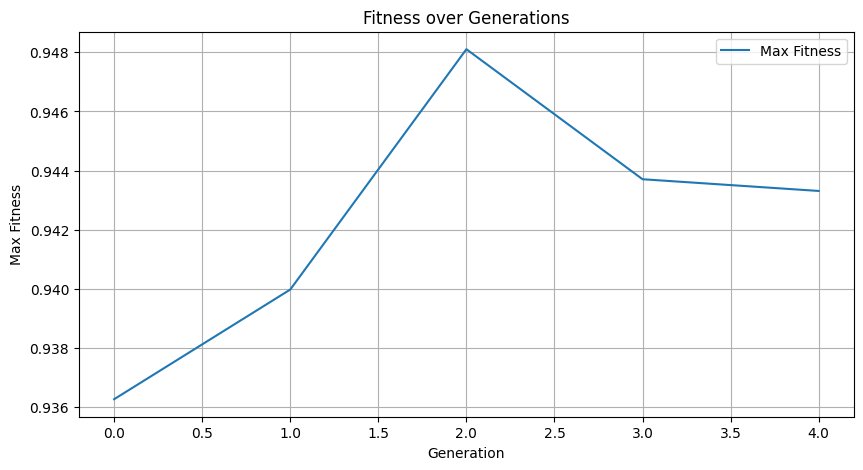

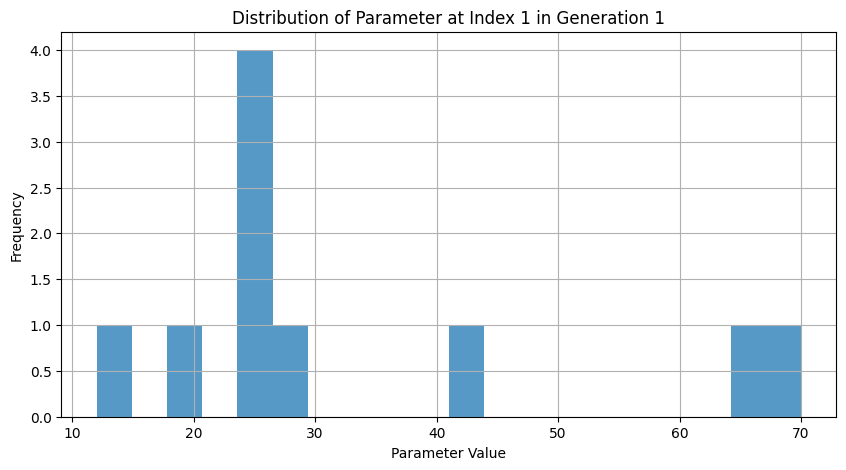

In [57]:
# import matplotlib.pyplot as plt

def plot_fitness(fitness_history):
    plt.figure(figsize=(10, 5))
    max_fitness = [max(fitness) for fitness in fitness_history]
    plt.plot(max_fitness, label='Max Fitness')
    plt.title('Fitness over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Max Fitness')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_parameter_distribution(parameter_history, generation, parameter_index):
    plt.figure(figsize=(10, 5))
    parameter_values = [gene[parameter_index] for gene in parameter_history[generation]]
    plt.hist(parameter_values, bins=20, alpha=0.75)
    plt.title(f'Distribution of Parameter at Index {parameter_index} in Generation {generation+1}')
    plt.xlabel('Parameter Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Call these functions after running `evolve()`
plot_fitness(fitness_history)
plot_parameter_distribution(parameter_history, 0, 1)


In [64]:
history


[(0, [110, 25, 7, 72, 9], 0.9362708330154419),
 (1, [110, 25, 7, 72, 9], 0.9399791955947876),
 (2, [126, 65, 5, 69, 7], 0.9481041431427002),
 (3, [110, 65, 7, 72, 7], 0.9437083601951599),
 (4, [102, 65, 7, 72, 9], 0.9433125257492065)]

In [59]:
"""
    'history' contains tuples of (generation, best_gene, fitness) and best_gene is 
        [batch_size, num_filters]. The best gene is retrieved
"""
best_gene = sorted(history, key=lambda x: x[2], reverse=True)[0][1]
best_batch_size, best_layer_config = best_gene[0], best_gene[1:]
best_gene, best_batch_size, best_layer_config

([126, 65, 5, 69, 7], 126, [65, 5, 69, 7])

In [66]:
# The best layer config from the best gene is used to instantiate the CNN model. 
best_model = CNNModel(best_layer_config,verbose=True)

c:\Users\Chulpan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [67]:
# The instantiateed model is then trained for 10 epochs.
best_model.train(x_train, y_train, x_val, y_val, best_batch_size, epochs=10)

Training model with batch size 126 and filters: [65, 69].
Epoch 1/10
1524/1524 ━━━━━━━━━━━━━━━━━━━━ 359s 235ms/step - accuracy: 0.7446 - loss: 4.2528 - val_accuracy: 0.9376 - val_loss: 0.2082
Epoch 2/10
1524/1524 ━━━━━━━━━━━━━━━━━━━━ 318s 208ms/step - accuracy: 0.9506 - loss: 0.1560 - val_accuracy: 0.9542 - val_loss: 0.1465
Epoch 3/10
1524/1524 ━━━━━━━━━━━━━━━━━━━━ 321s 211ms/step - accuracy: 0.9611 - loss: 0.1202 - val_accuracy: 0.9493 - val_loss: 0.1704
Epoch 4/10
1524/1524 ━━━━━━━━━━━━━━━━━━━━ 364s 239ms/step - accuracy: 0.9639 - loss: 0.1127 - val_accuracy: 0.9565 - val_loss: 0.1548
Epoch 5/10
1524/1524 ━━━━━━━━━━━━━━━━━━━━ 428s 281ms/step - accuracy: 0.9678 - loss: 0.1043 - val_accuracy: 0.9570 - val_loss: 0.1565
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


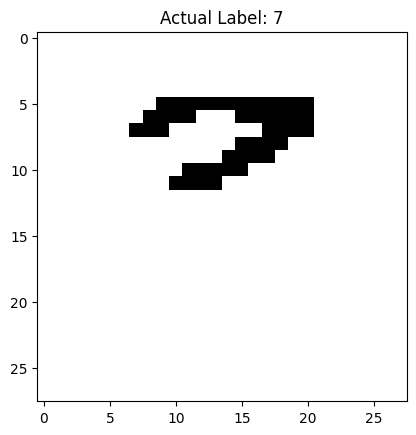

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Label: 7


In [76]:
index = np.random.randint(0, len(x_val))
random_image = x_val[index]
random_label = y_val[index]

plt.imshow(random_image.squeeze(), cmap='gray')
plt.title(f'Actual Label: {random_label}')
plt.show()

random_image_expanded = np.expand_dims(random_image, axis=0)
prediction = best_model.model.predict(random_image_expanded)
predicted_label = np.argmax(prediction)

print(f'Predicted Label: {predicted_label}')

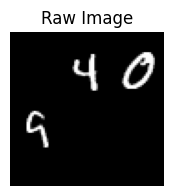

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


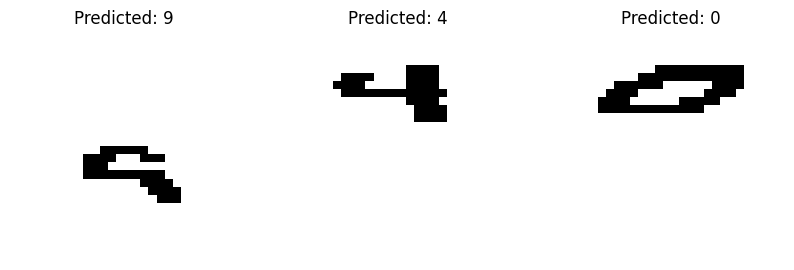

[9, 4, 0]

In [78]:
def pick_and_predict_single_image(trainpath):
    train_dirs = [d for d in os.listdir(trainpath) if os.path.isdir(os.path.join(trainpath, d))]
    chosen_dir = choice(train_dirs)
    full_path = os.path.join(trainpath, chosen_dir)
    image_name = choice(os.listdir(full_path))
    image_path = os.path.join(full_path, image_name)

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(6, 2))
    plt.imshow(img, cmap='gray')
    plt.title('Raw Image')
    plt.axis('off')
    plt.show()

    # Split the image
    img_array1 = img[:, :img.shape[1]//3]
    img_array2 = img[:, img.shape[1]//3:2*img.shape[1]//3]
    img_array3 = img[:, 2*img.shape[1]//3:]

    # Process each digit
    digits = [each_digit(img_array1), each_digit(img_array2), each_digit(img_array3)]

    # Predict each digit
    predictions = []
    for digit in digits:
        if digit is not None:
            digit = np.expand_dims(digit, axis=-1)
            digit = np.expand_dims(digit, axis=0)
            prediction = best_model.model.predict(digit)
            predicted_label = np.argmax(prediction)
            predictions.append(predicted_label)
        else:
            predictions.append(None)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    for i, ax in enumerate(axes):
        if digits[i] is not None:
            ax.imshow(digits[i], cmap='gray')
            ax.title.set_text(f'Predicted: {predictions[i]}')
        else:
            ax.imshow(np.zeros((28, 28)), cmap='gray')
            ax.title.set_text('No digit found')
        ax.axis('off')
    plt.show()

    return predictions

pick_and_predict_single_image(valpath)